## Introduction


A time series is a sequence of chronologically ordered data at equal or unequal intervals. The forecasting process consists of predicting the future value of a time series, either by modelling the series solely on the basis of its past behavior (autoregressive) or by using other external variables.




When working with time series, it is rarely necessary to predict only the next element in the series ( t+1). Instead, the most common goal is to forecast a whole future interval (( t+1), ..., ( t+n)) or a far future time ( t+n). Several strategies can be used to generate this type of forecast, skforecast has implemented the following for univariate time series forecasting:

Recursive multi-step forecasting: since the value  tn−1 is needed to predict  tn, and  tn−1 is unknown, a recursive process is applied in which, each new prediction, is based on the previous one. This process is known as recursive forecasting or recursive multi-step forecasting and can be easily generated with the ForecasterAutoreg and ForecasterAutoregCustom classes.

Direct multi-step forecasting: this method consists of training a different model for each step of the forecast horizon. For example, to predict the next 5 values of a time series, 5 different models are trained, one for each step. As a result, the predictions are independent of each other. This entire process is automated in the ForecasterAutoregDirect class.

This document shows an example of how to use forecasting methods to predict hourly electricity demand. Specifically, it introduces skforecast, a simple library that contains the classes and functions necessary to adapt any scikit-learn regression model to forecasting problems.

**Use Case**


A time series of electricity demand (MW) is available for the state of Victoria (Australia) from 2011-12-31 to 2014-12-31 is available. It is intended to generate a forecasting model capable of predicting the next day's energy demand at the hourly level.

In [3]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.io as pio
pio.templates.default = "seaborn"
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

**Data**


The data used in this document has been obtained from the R tsibbledata package. The dataset contains 5 columns and 52,608 complete records. The information in each column is:

Time: date and time of the record.

Date: date of the record.

Demand: electricity demand (MW).

Temperature: temperature in Melbourne, the capital of Victoria.

Holiday: indicates if the day is a public holiday.

In [15]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
data = pd.read_csv(url, sep=',')
data.head()

Time       Demand  Temperature        Date  Holiday
0  2011-12-31T13:00:00Z  4382.825174        21.40  2012-01-01     True
1  2011-12-31T13:30:00Z  4263.365526        21.05  2012-01-01     True
2  2011-12-31T14:00:00Z  4048.966046        20.70  2012-01-01     True
3  2011-12-31T14:30:00Z  3877.563330        20.55  2012-01-01     True
4  2011-12-31T15:00:00Z  4036.229746        20.40  2012-01-01     True

In [16]:
# Data preparation
# ==============================================================================
data = data.copy()
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data.head(2)

Demand  Temperature        Date  Holiday
Time                                                              
2011-12-31 13:00:00  4382.825174        21.40  2012-01-01     True
2011-12-31 13:30:00  4263.365526        21.05  2012-01-01     True

In [17]:
# Verify that a temporary index is complete
# ==============================================================================

(data.index == pd.date_range(start=data.index.min(), end=data.index.max(), freq='30T')).all()

True

In [19]:
print(f"Number of rows with missing values: {data.isnull().any(axis=1).mean()}")

Number of rows with missing values: 0.0


In [20]:
# Fill gaps in a temporary index
# ==============================================================================
# data.asfreq(freq='30min', fill_value=np.nan)

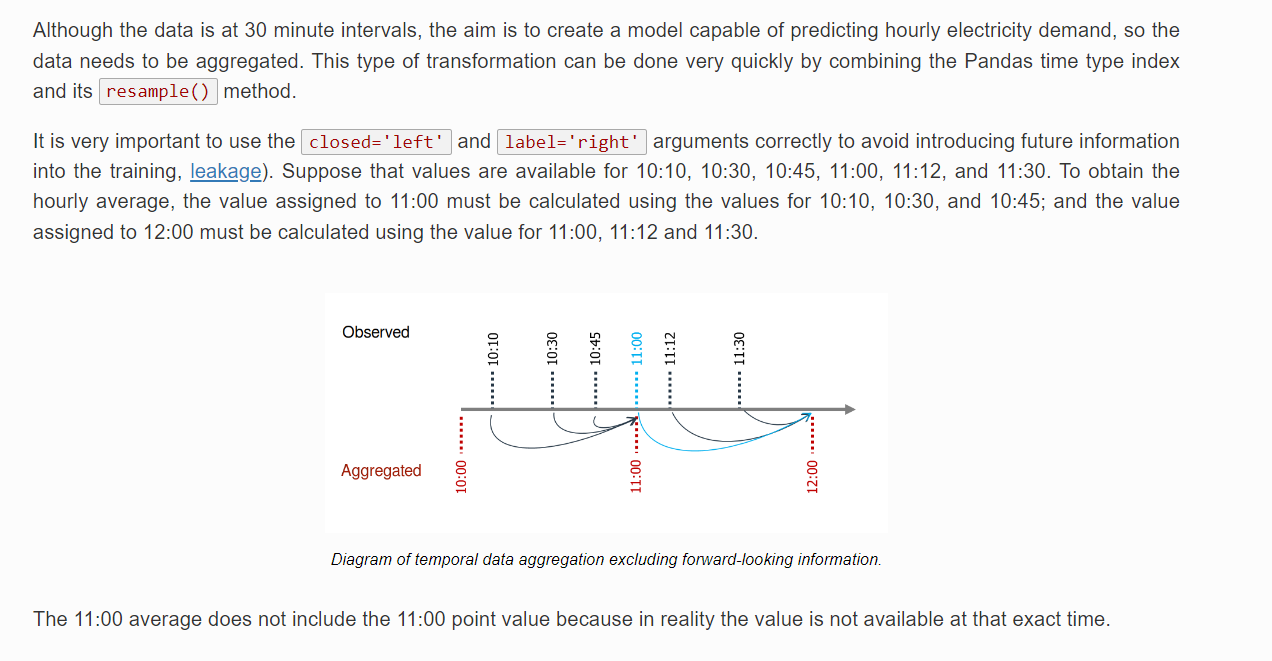

In [21]:
# Aggregating in 1H intervals
# ==============================================================================
# The Date column is eliminated so that it does not generate an error when aggregating.
# The Holiday column does not generate an error since it is Boolean and is treated as 0-1.
data = data.drop(columns='Date')
data = data.resample(rule='H', closed='left', label ='right').mean()
data

Demand  Temperature  Holiday
Time                                                  
2011-12-31 14:00:00  4323.095350       21.225      1.0
2011-12-31 15:00:00  3963.264688       20.625      1.0
2011-12-31 16:00:00  3950.913495       20.325      1.0
2011-12-31 17:00:00  3627.860675       19.850      1.0
2011-12-31 18:00:00  3396.251676       19.025      1.0
...                          ...          ...      ...
2014-12-31 09:00:00  4069.625550       21.600      0.0
2014-12-31 10:00:00  3909.230704       20.300      0.0
2014-12-31 11:00:00  3900.600901       19.650      0.0
2014-12-31 12:00:00  3758.236494       18.100      0.0
2014-12-31 13:00:00  3785.650720       17.200      0.0

[26304 rows x 3 columns]

The dataset starts on 2011-12-31 14:00:00 and ends on 2014-12-31 13:00:00. The first 10 and the last 13 records are discarded so that it starts on 2012-01-01 00:00:00 and ends on 2014-12-30 23:00:00. In addition, in order to optimize the hyperparameters of the model and evaluate its predictive ability, the data is divided into 3 sets, training, validation and test.

In [22]:
# Split data into train-val-test
# ==============================================================================
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00'].copy()
end_train = '2013-12-31 23:59:00'
end_validation = '2014-11-30 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2012-01-01 00:00:00 --- 2013-12-31 23:00:00  (n=17544)
Validation dates : 2014-01-01 00:00:00 --- 2014-11-30 23:00:00  (n=8016)
Test dates       : 2014-12-01 00:00:00 --- 2014-12-30 23:00:00  (n=720)


## Graphic exploration


When building a forecasting model, it may be useful to plot the time series values. This allows patterns such as trends and seasonality to be identified.

Full time series

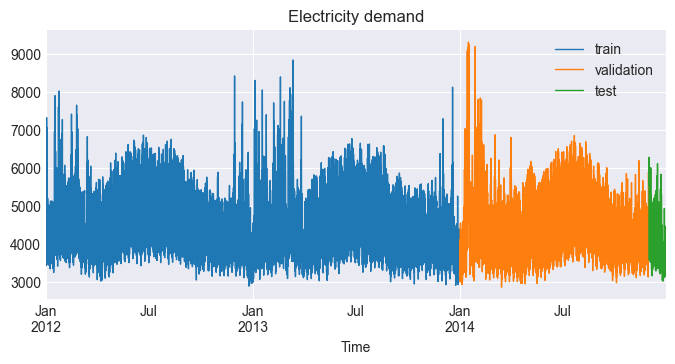

In [23]:
# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
data_train.Demand.plot(ax=ax, label='train', linewidth=1)
data_val.Demand.plot(ax=ax, label='validation', linewidth=1)
data_test.Demand.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Electricity demand')
ax.legend();

The graph above shows that electricity demand has an annual seasonality. There is a peak in July and very pronounced peaks in demand between January and March.

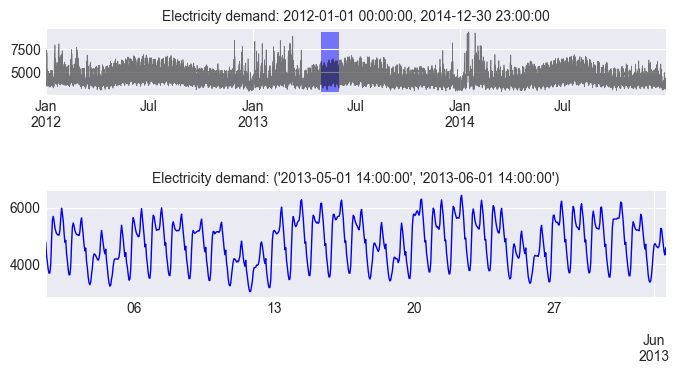

In [24]:
# Section of the time series

# Due to the variance of the time series, it is not possible to see the possible intraday pattern from a single chart.
# Zooming time series chart
# ==============================================================================
zoom = ('2013-05-01 14:00:00','2013-06-01 14:00:00')
fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)
main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])
data.Demand.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data.Demand)
max_y = max(data.Demand)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
data.loc[zoom[0]: zoom[1]].Demand.plot(ax=zoom_ax, color='blue', linewidth=1)
main_ax.set_title(f'Electricity demand: {data.index.min()}, {data.index.max()}', fontsize=10)
zoom_ax.set_title(f'Electricity demand: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)

When the time series are zoomed in, a clear weekly seasonality can be seen, with higher consumption during the working week (Monday to Friday) and lower consumption at weekends. There is also a clear correlation between the consumption of one day and that of the previous day.

## Annual, weekly and daily seasonality

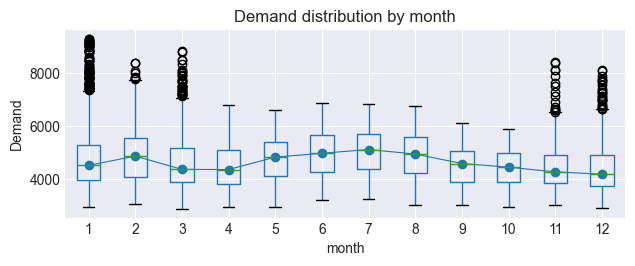

In [25]:
# Boxplot for annual seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data['month'] = data.index.month
data.boxplot(column='Demand', by='month', ax=ax,)
data.groupby('month')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by month')
fig.suptitle('');

It is observed that there is an annual seasonality, with higher (median) demand values in June, July, and August, and with high demand peaks in November, December, January, February, and March.

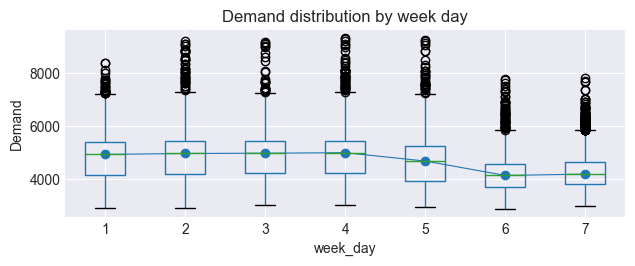

In [26]:
# Boxplot for weekly seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='Demand', by='week_day', ax=ax)
data.groupby('week_day')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by week day')
fig.suptitle('');

Weekly seasonality shows lower demand values during the weekend.

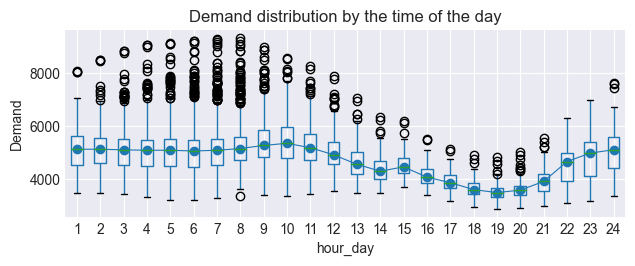

In [27]:
# Boxplot for daily seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data['hour_day'] = data.index.hour + 1
data.boxplot(column='Demand', by='hour_day', ax=ax)
data.groupby('hour_day')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by the time of the day')
fig.suptitle('');

There is also a daily seasonality, with demand falling between 16:00 and 21:00 hours.

# Holidays and non-holiday days

NameError: name 'sns' is not defined

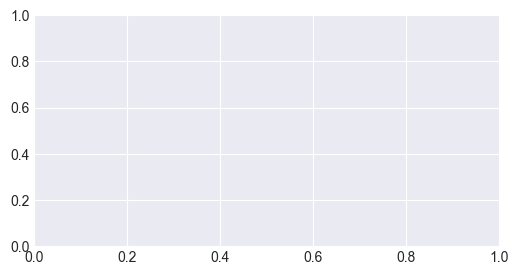

In [28]:
# Violinplot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
sns.violinplot(
    x       = 'Demand',
    y       = 'Holiday',
    data    = data.assign(Holiday = data.Holiday.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribution of demand between holidays and non-holidays')
ax.set_xlabel('Demand')
ax.set_ylabel('Holiday');

Consumption tends to be lower on public holidays

# Autocorrelation plots

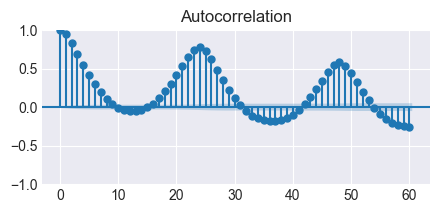

In [29]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_acf(data.Demand, ax=ax, lags=60)
plt.show()

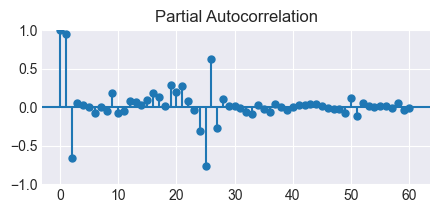

In [30]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_pacf(data.Demand, ax=ax, lags=60)
plt.show()

The autocorrelation and partial autocorrelation plots show a clear relationship between demand in one hour and the previous hours, and between demand in one hour and the same hour in previous days. This type of correlation is an indication that autoregressive models can work well.

## Recursive multi-step forecasting

A recursive autoregressive model (ForecasterAutoreg) is created and trained from a linear regression model with a Ridge penalty and a time window of 24 lags. This means that for each prediction, the demand values of the previous 24 hours are used as predictors.

In [31]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 24,
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=data.loc[:end_validation, 'Demand'])
forecaster

ForecasterAutoreg 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-10-23 01:00:12 
Last fit date: 2023-10-23 01:00:12 
Skforecast version: 0.10.1 
Python version: 3.8.6 
Forecaster id: None 

**Backtest**

It evaluates how the model would have behaved if it had been trained on data from 2012-01-01 00:00 to 2014-11-30 23:59 and then every day at 23:59 it predicted the next 24 hours. This type of evaluation, known as backtesting, can be easily implemented with the function backtesting_forecaster(). This function returns an error metric in addition to the predictions.

In [32]:
# Backtest
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Demand'],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data.loc[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = True,
                          show_progress      = True
                    )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 25560
Number of observations used for backtesting: 720
    Number of folds: 30
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-01 00:00:00 -- 2014-12-01 23:00:00  (n=24)
Fold: 1
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-02 00:00:00 -- 2014-12-02 23:00:00  (n=24)
Fold: 2
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-03 00:00:00 -- 2014-12-03 23:00:00  (n=24)
Fold: 3
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-04 00:00:00 -- 2014-12-04 23:00:00  (n=24)
Fold: 4
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-05

100%|██████████| 30/30 [00:00<00:00, 82.90it/s]


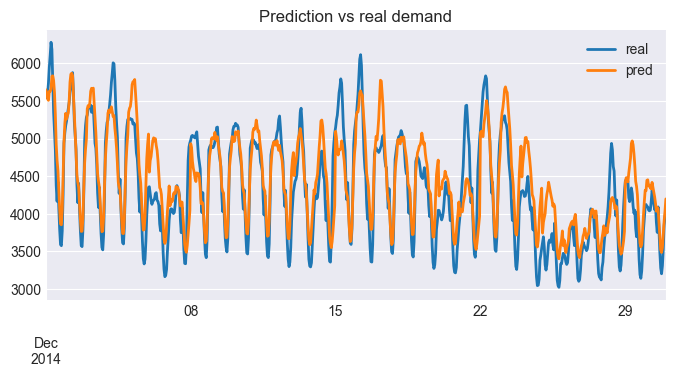

In [33]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, 'Demand'].plot(ax=ax, linewidth=2, label='real')
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();

In [35]:
# Backtest error
# ==============================================================================
print(f'Backtest error: {metric}')

Backtest error: 289.5191331582594


## Hyperparameter tuning


The trained ForecasterAutoreg object used the first 24 lags and a Ridge model with the default hyperparameters. However, there is no reason why these values are the most appropriate.

To identify the best combination of lags and hyperparameters, a Grid Search with validation by Backtesting is used. This process consists of training a model with different combinations of hyperparameters and lags and evaluating its predictive capacity. In the search process, it is important to evaluate the models using only the validation data and not to include the test data, which is only used to evaluate the final model.

In [36]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 24, # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )

# Lags used as predictors
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Regressor's hyperparameters
param_grid = {'alpha': np.logspace(-3, 5, 10)}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'Demand'],
                   steps              = 24,
                   metric             = 'mean_absolute_error',
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   initial_train_size = len(data[:end_train]),
                   refit              = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = True
               )

Number of models compared: 30.


lags grid: 100%|██████████| 3/3 [01:10<00:00, 23.62s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'alpha': 215.44346900318823}
  Backtesting metric: 257.8430984508259



In [37]:
# Grid Search results
# ==============================================================================
results_grid

lags  \
26                  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
25                  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
24                  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
23                  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
22                  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
21                  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
20                  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
10  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
12  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
13  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
14  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
27                  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
16  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
17  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
18  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
28                  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
19  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
29                  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
7                                     [1, 2, 3, 4, 5]   
0                                     [1, 2, 3, 4, 5]   
1                                     [1, 2, 3, 4, 5]   
2                                     [1, 2, 3, 4, 5]   
3                                     [1, 2, 3, 4, 5]   
4                                     [1, 2, 3, 4, 5]   
5                                     [1, 2, 3, 4, 5]   
6                                     [1, 2, 3, 4, 5]   
8                                     [1, 2, 3, 4, 5]   
9                                     [1, 2, 3, 4, 5]   

                             params  mean_absolute_error          alpha  
26    {'alpha': 215.44346900318823}           257.843098     215.443469  
25    {'alpha': 27.825594022071257}           290.527024      27.825594  
24     {'alpha': 3.593813663804626}           306.626903       3.593814  
23   {'alpha': 0.46415888336127775}           309.392653       0.464159  
22   {'alpha': 0.05994842503189409}           309.775993       0.059948  
21  {'alpha': 0.007742636826811269}           309.825950       0.007743  
20                 {'alpha': 0.001}           309.832409       0.001000  
10                 {'alpha': 0.001}           325.041130       0.001000  
11  {'alpha': 0.007742636826811269}           325.043580       0.007743  
12   {'alpha': 0.05994842503189409}           325.062545       0.059948  
13   {'alpha': 0.46415888336127775}           325.208825       0.464159  
14     {'alpha': 3.593813663804626}           326.307886       3.593814  
15    {'alpha': 27.825594022071257}           333.397909      27.825594  
27    {'alpha': 1668.1005372000557}           356.641082    1668.100537  
16    {'alpha': 215.44346900318823}           360.848676     215.443469  
17    {'alpha': 1668.1005372000557}           396.346551    1668.100537  
18    {'alpha': 12915.496650148827}           421.013605   12915.496650  
28    {'alpha': 12915.496650148827}           443.558961   12915.496650  
19              {'alpha': 100000.0}           540.701488  100000.000000  
29              {'alpha': 100000.0}           545.558638  100000.000000  
7     {'alpha': 1668.1005372000557}           611.233913    1668.100537  
0                  {'alpha': 0.001}           612.352191       0.001000  
1   {'alpha': 0.007742636826811269}           612.352531       0.007743  
2    {'alpha': 0.05994842503189409}           612.355162       0.059948  
3    {'alpha': 0.46415888336127775}           612.375445       0.464159  
4      {'alpha': 3.593813663804626}           612.528084       3.593814  
5     {'alpha': 27.825594022071257}           613.477734      27.825594  
6     {'alpha': 215.44346900318823}           615.109171     215.443469  
8     {'alpha': 12915.496650148827}           625.105139   12915.496650  
9               {'alpha': 100000.0}           681.832812  100

In [38]:
forecaster

ForecasterAutoreg 
Regressor: Ridge(alpha=215.44346900318823, random_state=123) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 215.44346900318823, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-10-23 01:03:29 
Last fit date: 2023-10-23 01:04:40 
Skforecast version: 0.10.1 
Python version: 3.8.6 
Forecaster id: None 

Backtest with test data


Once the best model has been identified and trained, its error in predicting the test data is calculated.

100%|██████████| 30/30 [00:00<00:00, 135.49it/s]


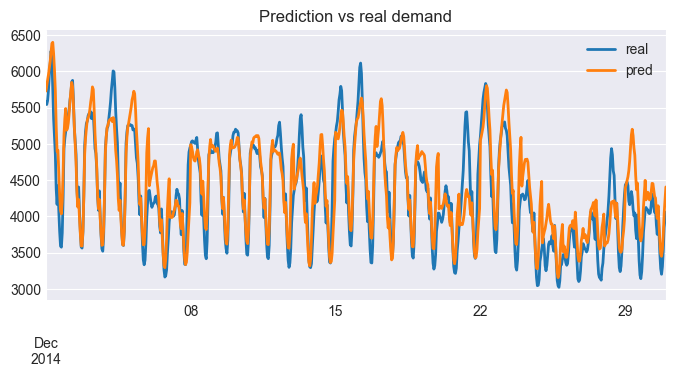

In [39]:
# Backtest final model
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Demand'],
                          steps              = 24,
                          metric             = mean_absolute_error,
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, 'Demand'].plot(linewidth=2, label='real', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();

In [40]:
# Backtest error
# ==============================================================================
print(f'Backtest error: {metric}')

Backtest error: 251.92726486972057


## Prediction intervals


A prediction interval defines the interval within which the true value of "y" can be expected to be found with a given probability.

In [41]:
# Backtest with test data and intervals
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster          = forecaster,
                          y                   = data['Demand'],
                          steps               = 24,
                          metric              = 'mean_absolute_error',
                          initial_train_size  = len(data.loc[:end_validation]),
                          refit               = False,
                          interval            = [10, 90],
                          n_boot              = 500,
                          in_sample_residuals = True,
                          n_jobs             = 'auto',
                          verbose             = False,
                          show_progress       = True
                      )

print('Backtesting metric:', metric)
predictions.head(5)

100%|██████████| 30/30 [02:14<00:00,  4.50s/it]

Backtesting metric: 251.92726486972057


pred  lower_bound  upper_bound
2014-12-01 00:00:00  5727.844947  5598.931844  5849.598860
2014-12-01 01:00:00  5802.807448  5599.126464  5974.887546
2014-12-01 02:00:00  5879.948808  5619.868497  6113.714851
2014-12-01 03:00:00  5953.414468  5657.436246  6239.937101
2014-12-01 04:00:00  6048.594433  5697.672143  6342.846047

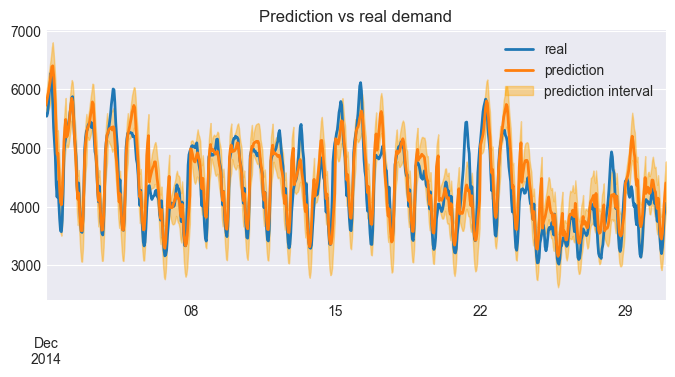

In [42]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, 'Demand'].plot(linewidth=2, label='real', ax=ax)
predictions.iloc[:, 0].plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.fill_between(
    predictions.index,
    predictions.iloc[:, 1],
    predictions.iloc[:, 2],
    alpha = 0.4,
    color = 'orange',
    label = 'prediction interval' 
)
ax.legend();

In [43]:
# Predicted interval coverage
# ==============================================================================
inside_interval = np.where(
                      (data.loc[end_validation:, 'Demand'] >= predictions["lower_bound"]) & \
                      (data.loc[end_validation:, 'Demand'] <= predictions["upper_bound"]),
                      True,
                      False
                  )

coverage = inside_interval.mean()
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

Predicted interval coverage: 79.03 %


The predicted interval has a lower coverage than expected (80%). This may be due to the model's very high error for days 21, 24 and 25. These days fall within the Christmas holiday period, which is usually characterized by a different consumer behavior than the rest of the month.

## Anticipated daily forecast


Up to now, the model has been evaluated on the assumption that the next day's forecasts are run immediately after the previous day. In practice, this is not very useful as there is no time to manage the first hours of the next day.

Now let us suppose that the predictions for the following day have to be made at 11:00 each day in order to have sufficient leeway. This means that at 11:00 on day  D
  you have to forecast the hours [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] of the same day and the hours [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] of day  D+1
 . This means that a total of 36 hours into the future have to be predicted, although only the last 24 hours have to be stored.

This type of evaluation can be performed using the backtesting_forecaster() function and its gap parameter. In addition, the allow_incomplete_fold parameter allows the last fold to be excluded from the analysis if it doesn't have the same size as the required number of steps. The process adapted to this scenario is run on a daily basis and consists of the following steps:

At 11:00 a.m. on the first day of the test set, the next 36 hours (the remaining 12 hours of the day plus 24 hours of the following day) are predicted.

Only the next day's predictions are stored, that is from position 12 onwards.

The next day until 11:00 a.m. is added to the test set.

The process is repeated.

Thus, at 11:00 a.m. each day, the model has access to the actual demand values recorded up to that time.

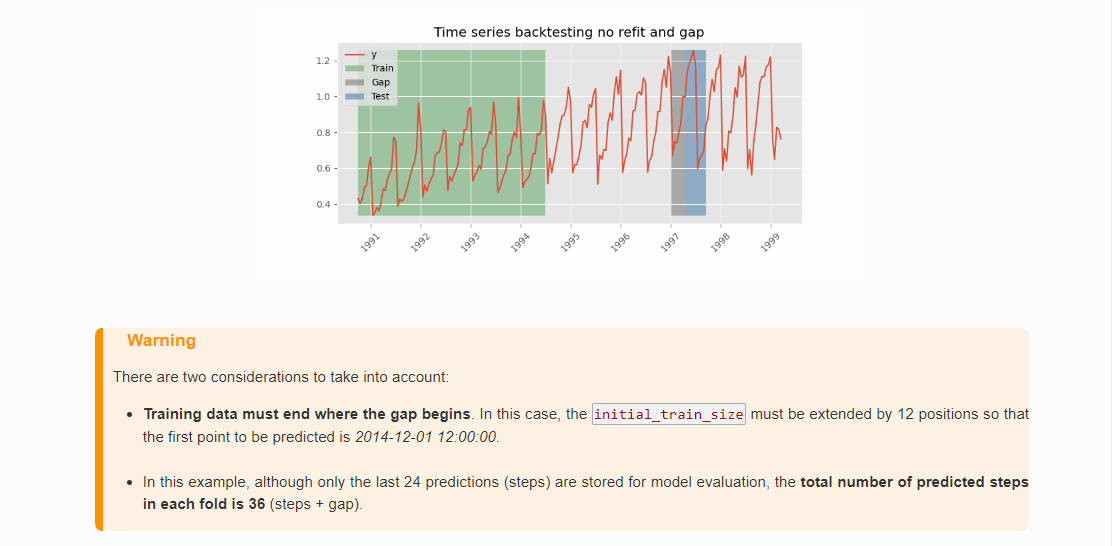

In [61]:
# End of initial_train_size + 12 positions
# ==============================================================================
data.iloc[:len(data.loc[:end_validation])+12].tail(2)

Demand  Temperature  Holiday  month  week_day  \
Time                                                                      
2014-12-01 10:00:00  5084.011257        19.90      0.0     12         1   
2014-12-01 11:00:00  4851.066658        19.35      0.0     12         1   

                     hour_day  
Time                           
2014-12-01 10:00:00        11  
2014-12-01 11:00:00        12

In [62]:
# Backtesting with gap
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['Demand'],
                          steps                 = 24,
                          metric                = 'mean_absolute_error',
                          initial_train_size    = len(data.loc[:end_validation])+12,
                          gap                   = 12,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True  
                      )

print("")
print('Backtesting metric:', metric)
predictions.head(5)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 25572
Number of observations used for backtesting: 708
    Number of folds: 29
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 12

Fold: 0
    Training:   2012-01-01 00:00:00 -- 2014-12-01 11:00:00  (n=25572)
    Validation: 2014-12-02 00:00:00 -- 2014-12-02 23:00:00  (n=24)
Fold: 1
    Training:   2012-01-01 00:00:00 -- 2014-12-01 11:00:00  (n=25572)
    Validation: 2014-12-03 00:00:00 -- 2014-12-03 23:00:00  (n=24)
Fold: 2
    Training:   2012-01-01 00:00:00 -- 2014-12-01 11:00:00  (n=25572)
    Validation: 2014-12-04 00:00:00 -- 2014-12-04 23:00:00  (n=24)
Fold: 3
    Training:   2012-01-01 00:00:00 -- 2014-12-01 11:00:00  (n=25572)
    Validation: 2014-12-05 00:00:00 -- 2014-12-05 23:00:00  (n=24)
Fold: 4
    Training:   2012-01-01 00:00:00 -- 2014-12-01 11:00:00  (n=25572)
    Validation: 2014-12-0

100%|██████████| 29/29 [00:00<00:00, 55.72it/s]


Backtesting metric: 374.3373175926861


pred
2014-12-02 00:00:00  5154.952086
2014-12-02 01:00:00  5183.487126
2014-12-02 02:00:00  5263.237055
2014-12-02 03:00:00  5397.278836
2014-12-02 04:00:00  5571.542647

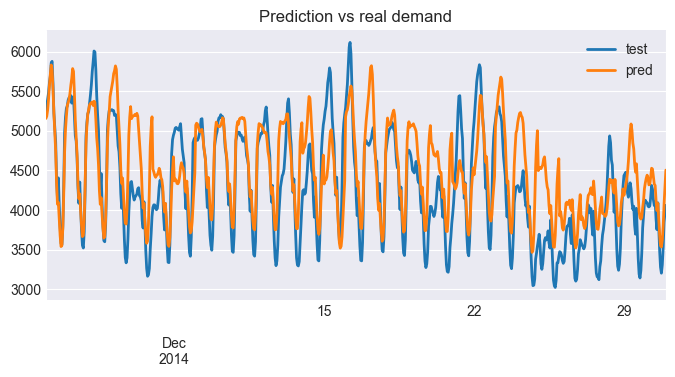

In [63]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();

In [65]:
# Backtest error
# ==============================================================================
error = mean_absolute_error(
            y_true = data.loc[predictions.index, 'Demand'],
            y_pred = predictions
        )

print(f"Backtest error: {error}")

#As expected, the error increases as the forecast horizon increases from 24 to 36 hours.

Backtest error: 374.3373175926861


## Forecasting with exogenous variables


In the previous example, only lags of the predicted variable itself were used as predictors. In some scenarios, it is possible to have information about other variables, whose future value is known and these can be used as additional predictors in the model. Typical examples are:

Holidays (local, national...)

Month of the year

Day of the week

Time of day

In this use case, the graphical analysis showed evidence that demand is lower on holidays. Whether a day is a holiday or not can be known in the future, so it can be used as an exogenous variable. See how it affects the model when the Holiday variable, which is available in the dataset, is included as a predictor.

## Forecaster Training

In [66]:
# The Holiday column is converted from boolean to integer
# ==============================================================================
data['Holiday'] = data['Holiday'].astype(int)
data_train['Holiday'] = data_train['Holiday'].astype(int)
data_test['Holiday'] = data_test['Holiday'].astype(int)

In [67]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = Ridge(alpha=215.44, random_state=123),
                 lags             = [1, 2, 3, 23, 24, 25, 47, 48, 49],
                 transformer_y    = StandardScaler(),
                 transformer_exog = None
             )

forecaster.fit(y=data.loc[:end_validation, 'Demand'], exog=data.loc[:end_validation, 'Holiday'])
forecaster

ForecasterAutoreg 
Regressor: Ridge(alpha=215.44, random_state=123) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: Holiday 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 215.44, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-10-24 23:11:38 
Last fit date: 2023-10-24 23:11:38 
Skforecast version: 0.10.1 
Python version: 3.8.6 
Forecaster id: None 

In [68]:
# Backtest with gap
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['Demand'],
                          exog                  = data['Holiday'],
                          steps                 = 24,
                          metric                = 'mean_absolute_error',
                          initial_train_size    = len(data.loc[:end_validation])+12,
                          gap                   = 12,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True  
                      )

100%|██████████| 29/29 [00:00<00:00, 87.68it/s]


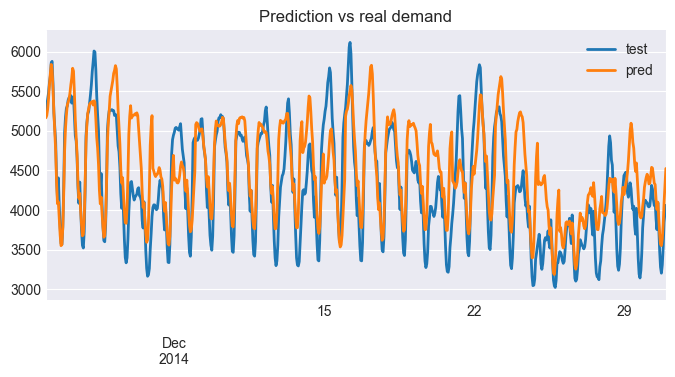

In [69]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();

In [70]:
# Backtest error
# ==============================================================================
error = mean_absolute_error(
            y_true = data.loc[predictions.index, 'Demand'],
            y_pred = predictions
        )

print(f"Backtest error: {error}")

Backtest error: 359.1077190771288


Using whether the day is a holiday or not as an exogenous variable slightly reduces the prediction error from 374.3 to 359.1. See what happens when we add as predictors whether the previous and the next day are holidays, the day of the week and the time of the day.

In [72]:
# Creation of new exogenous variables
# ==============================================================================
# Since it is hourly data and starts at 00:00, the values must be shifted 
# by 24 hours
data['Holiday_day_before'] = data['Holiday'].shift(24)
data['Holiday_next_day']   = data['Holiday'].shift(-24)
data = data.dropna()

# One hot encoding of week_day and hour_day
# ==============================================================================
one_hot_encoder = make_column_transformer(
                      (
                          OneHotEncoder(sparse_output=False, drop='if_binary'),
                          ['week_day', 'hour_day'],
                      ),
                      remainder="passthrough",
                      verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

data = one_hot_encoder.fit_transform(data)
data.head(3)

week_day_1  week_day_2  week_day_3  week_day_4  \
Time                                                                  
2012-01-03 00:00:00         0.0         1.0         0.0         0.0   
2012-01-03 01:00:00         0.0         1.0         0.0         0.0   
2012-01-03 02:00:00         0.0         1.0         0.0         0.0   

                     week_day_5  week_day_6  week_day_7  hour_day_1  \
Time                                                                  
2012-01-03 00:00:00         0.0         0.0         0.0         1.0   
2012-01-03 01:00:00         0.0         0.0         0.0         0.0   
2012-01-03 02:00:00         0.0         0.0         0.0         0.0   

                     hour_day_2  hour_day_3  ...  hour_day_21  hour_day_22  \
Time                                         ...                             
2012-01-03 00:00:00         0.0         0.0  ...          0.0          0.0   
2012-01-03 01:00:00         1.0         0.0  ...          0.0          0.0   
2012-01-03 02:00:00         0.0         1.0  ...          0.0          0.0   

                     hour_day_23  hour_day_24       Demand  Temperature  \
Time                                                                      
2012-01-03 00:00:00          0.0          0.0  6378.705137       26.450   
2012-01-03 01:00:00          0.0          0.0  6699.486540       26.425   
2012-01-03 02:00:00          0.0          0.0  6948.331814       26.800   

                     Holiday  month  Holiday_day_before  Holiday_next_day  
Time                                                                       
2012-01-03 00:00:00        0      1                 1.0               0.0  
2012-01-03 01:00:00        0      1                 1.0               0.0  
2012-01-03 02:00:00        0      1                 1.0               0.0  

[3 rows x 37 columns]

In [73]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = Ridge(alpha=215.44, random_state=123),
                 lags             = [1, 2, 3, 23, 24, 25, 47, 48, 49],
                 transformer_y    = StandardScaler(),
                 transformer_exog = None
             )

exog = [col for col in data.columns if col.startswith(('week_day', 'hour', 'Holiday'))]
forecaster.fit(y=data.loc[:end_validation, 'Demand'], exog=data.loc[:end_validation, exog])

# Backtest with gap
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['Demand'],
                          exog                  = data[exog],
                          steps                 = 24,
                          metric                = 'mean_absolute_error',
                          initial_train_size    = len(data.loc[:end_validation])+12,
                          gap                   = 12,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True  
                      )

# Backtest error
# ==============================================================================
error = mean_absolute_error(
            y_true = data.loc[predictions.index, 'Demand'],
            y_pred = predictions
        )

print("")
print(f"Backtest error: {error}")

100%|██████████| 27/27 [00:00<00:00, 90.67it/s]


Backtest error: 280.81426346950593


## Direct multi-step forecasting

The ForecasterAutoreg and ForecasterAutoregCustom models follow a recursive multi-step strategy where each new prediction builds on the previous one. An alternative is to train a model for each of the steps to be predicted. This strategy, commonly known as direct multi-step forecasting, is computationally more expensive than the recursive strategy because it requires the training of multiple models. However, in some scenarios it provides better results. This type of model can be obtained using the ForecasterAutoregDirect.

Unlike when using ForecasterAutoreg or ForecasterAutoregCustom, in ForecasterAutoregDirect type models, the number of steps to predict must be specified when initializing the forecaster.

In [74]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor        = LGBMRegressor(random_state=123),
                 steps            = 36, # Steps + gap
                 lags             = 24, # This value will be replaced in the grid search
                 transformer_y    = None,
                 transformer_exog = None
             )

# Lags used as predictors
lags_grid = [[1, 2, 3, 23, 24], [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [4, 6]}

results_grid = grid_search_forecaster(
                   forecaster            = forecaster,
                   y                     = data.loc[:end_validation, 'Demand'],
                   exog                  = data.loc[:end_validation, exog],
                   steps                 = 24,
                   metric                = 'mean_absolute_error',
                   param_grid            = param_grid,
                   lags_grid             = lags_grid,
                   initial_train_size    = len(data.loc[:end_train])+12,
                   gap                   = 12,
                   allow_incomplete_fold = True,
                   refit                 = False,
                   return_best           = True,
                   n_jobs                = 'auto',
                   verbose               = False,
                   show_progress         = True
               )

Number of models compared: 8.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

lags grid:  50%|█████     | 1/2 [01:18<01:18, 78.40s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

lags grid: 100%|██████████| 2/2 [02:50<00:00, 85.20s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'max_depth': 6, 'n_estimators': 500}
  Backtesting metric: 242.82980096939627



In [75]:
# Grid Search results
# ==============================================================================
results_grid

lags                                 params  \
7  [1, 2, 3, 23, 24, 25, 47, 48, 49]  {'max_depth': 6, 'n_estimators': 500}   
3                  [1, 2, 3, 23, 24]  {'max_depth': 6, 'n_estimators': 500}   
5  [1, 2, 3, 23, 24, 25, 47, 48, 49]  {'max_depth': 4, 'n_estimators': 500}   
1                  [1, 2, 3, 23, 24]  {'max_depth': 4, 'n_estimators': 500}   
6  [1, 2, 3, 23, 24, 25, 47, 48, 49]  {'max_depth': 6, 'n_estimators': 100}   
2                  [1, 2, 3, 23, 24]  {'max_depth': 6, 'n_estimators': 100}   
0                  [1, 2, 3, 23, 24]  {'max_depth': 4, 'n_estimators': 100}   
4  [1, 2, 3, 23, 24, 25, 47, 48, 49]  {'max_depth': 4, 'n_estimators': 100}   

   mean_absolute_error  max_depth  n_estimators  
7           242.829801          6           500  
3           246.870457          6           500  
5           249.469916          4           500  
1           255.628012          4           500  
6           271.929453          6           100  
2           272.223900          6           100  
0           306.879590          4           100  
4           307.811363          4           100

Anticipated daily forecast


In [76]:
# Backtest with gap
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['Demand'],
                          exog                  = data[exog],
                          steps                 = 24,
                          metric                = 'mean_absolute_error',
                          initial_train_size    = len(data.loc[:end_validation])+12,
                          gap                   = 12,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True  
                      )

 26%|██▌       | 7/27 [00:00<00:00, 60.04it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

 78%|███████▊  | 21/27 [00:00<00:00, 56.37it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

100%|██████████| 27/27 [00:00<00:00, 55.90it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

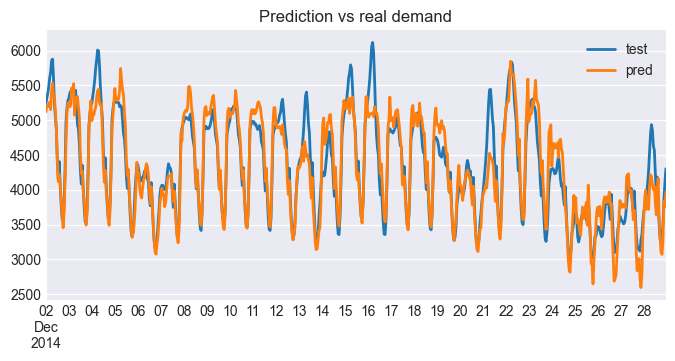

In [77]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();

In [78]:
# Backtest error
# ==============================================================================
error = mean_absolute_error(
            y_true = data.loc[predictions.index, 'Demand'],
            y_pred = predictions
        )

print(f"Backtest error: {error}")

Backtest error: 202.7771631276178
